In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#Cargamos los datos a trabajar

x_train_pre=np.load("./data/train_signals.npy")
y_train_pre=np.load("./data/train_marks.npy")
trainLen=len(x_train_pre)

x_val_pre=np.load("./data/val_signals.npy")
y_val_pre=np.load("./data/val_marks.npy")
valLen=len(x_val_pre)

x_test_pre=np.load("./data/test_signals.npy")
y_test_pre=np.load("./data/test_marks.npy")
testLen=len(x_test_pre)

#Creamos una funcion que muestree a un ratio deseado

def sampling(signals,samples,lenght,rate):
    x_new=[]
    for i in signals:
        x=[]
        for j in range(0,lenght,rate):
            x.append(i[j])
        x_new.append(x)
    return np.array(x_new)

#Obtenemos los nuevos resultados de nuestras señales a trabajar

x_train=sampling(x_train_pre,trainLen,800,4)
x_val=sampling(x_val_pre,valLen,800,4)
x_test=sampling(x_test_pre,testLen,800,4)

#Creamos una funcion que clasifique con 1 o 0 los valores de la señal a trabajar

def oneHot(marks,lenght,rate):
    y_new=[]
    for i in marks:
        y=[]
        for j in range(0,lenght,rate):
            if(i[0]<=j & j<=i[1]):
                y.append(1)
            else:
                y.append(0)
        y_new.append(y)
    return np.array(y_new)

#Obtenemos los nuevos resultados de nuestras marcas a trabajar

y_train=oneHot(y_train_pre,800,4)
y_val=oneHot(y_val_pre,800,4)
y_test=oneHot(y_test_pre,800,4)

x_train2=np.expand_dims(x_train,2)
y_train2=np.expand_dims(y_train,2)

x_val2=np.expand_dims(x_val,2)
y_val2=np.expand_dims(y_val,2)

x_test2=np.expand_dims(x_test,2)
y_test2=np.expand_dims(y_test,2)

BATCH_SIZE=1

training_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train2, y_train)).shuffle(buffer_size=1024).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test2, y_test)).shuffle(buffer_size=1024).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (x_val2, y_val)).shuffle(buffer_size=1024).batch(BATCH_SIZE)

time=np.arange(0,800,4)

In [3]:
x_train.shape

(4463, 200)

In [12]:
#Modelo Paper
prob=0.5
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv1D(40, 7, activation='elu',padding="same"))
model.add(tf.keras.layers.MaxPool1D(pool_size=5,strides=1,padding="same"))

model.add(tf.keras.layers.Conv1D(40, 7, activation='elu',padding="same"))
model.add(tf.keras.layers.MaxPool1D(pool_size=5,strides=1,padding="same"))

model.add(tf.keras.layers.Conv1D(40, 7, activation='elu',padding="same"))
model.add(tf.keras.layers.MaxPool1D(pool_size=5,strides=1,padding="same"))

model.add(tf.keras.layers.Conv1D(40, 7, activation='elu',padding="same"))
model.add(tf.keras.layers.MaxPool1D(pool_size=5,strides=1,padding="same"))

model.add(tf.keras.layers.Conv1D(40, 7, activation='elu',padding="same"))
model.add(tf.keras.layers.MaxPool1D(pool_size=5,strides=1,padding="same"))

model.add(tf.keras.layers.Conv1D(1, 1, activation='elu',padding="same"))

model.build(input_shape=(None,200,1))

model.compile(loss='categorical_crossentropy',optimizer="adam",  metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 200, 40)           320       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 200, 40)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 200, 40)           11240     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 200, 40)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 200, 40)           11240     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 200, 40)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 200, 40)          

In [34]:
#Modelo Propuesto

model2 = tf.keras.Sequential()

model2.add(tf.keras.layers.Conv1D(16, 7, activation='elu'))
model2.add(tf.keras.layers.MaxPool1D(pool_size=5,strides=2))

model2.add(tf.keras.layers.Conv1D(32, 7, activation='elu'))
model2.add(tf.keras.layers.Dropout(prob))
model2.add(tf.keras.layers.MaxPool1D(pool_size=5,strides=2))

model2.add(tf.keras.layers.Conv1D(48, 7, activation='elu'))
model2.add(tf.keras.layers.Dropout(prob))
model2.add(tf.keras.layers.MaxPool1D(pool_size=5,strides=2))

model2.add(tf.keras.layers.Conv1D(64, 7, activation='elu'))
model2.add(tf.keras.layers.Dropout(prob))
model2.add(tf.keras.layers.MaxPool1D(pool_size=5,strides=2))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(50, activation=tf.nn.relu, name='fc3'))
model2.add(tf.keras.layers.Dropout(0.5))

model2.add(tf.keras.layers.Dense(200, activation=tf.nn.relu, name='fc4'))


model2.build(input_shape=(None,200,1))

model2.compile(loss='categorical_crossentropy',optimizer="adam",  metrics=['accuracy'])

model2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 194, 16)           128       
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 95, 16)            0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 89, 32)            3616      
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 43, 32)            0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 37, 48)            10800     
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 17, 48)            0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 11, 64)          

In [13]:
# Falla :c

model.fit(
    training_dataset, 
    epochs=100,
    steps_per_epoch=100,
    validation_data=val_dataset,
    validation_freq=1,
    callbacks=[tf.keras.callbacks.TensorBoard('./logs/esquere', update_freq=100)]
)



Epoch 1/100
100/100 [==============================] - 5s 46ms/step - loss: 202.2101 - accuracy: 0.5641 - val_loss: 233.4452 - val_accuracy: 0.7797
Epoch 2/100
100/100 [==============================] - 3s 26ms/step - loss: 209.6015 - accuracy: 0.8022 - val_loss: 233.4452 - val_accuracy: 0.7797
Epoch 3/100
100/100 [==============================] - 3s 26ms/step - loss: 236.3579 - accuracy: 0.7770 - val_loss: 233.4452 - val_accuracy: 0.7797
Epoch 4/100
100/100 [==============================] - 3s 26ms/step - loss: 227.9866 - accuracy: 0.7849 - val_loss: 233.4452 - val_accuracy: 0.7797
Epoch 5/100
100/100 [==============================] - 3s 26ms/step - loss: 224.8605 - accuracy: 0.7878 - val_loss: 233.4454 - val_accuracy: 0.7797
Epoch 6/100
100/100 [==============================] - 3s 28ms/step - loss: 234.1857 - accuracy: 0.7790 - val_loss: 233.4451 - val_accuracy: 0.7797
Epoch 7/100
100/100 [==============================] - 3s 27ms/step - loss: 231.8013 - accuracy: 0.7812 - val_lo

In [ ]:
training_dataset

In [ ]:
x_train2.shape

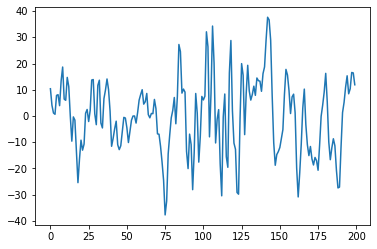

In [14]:
plt.plot(x_train[0])

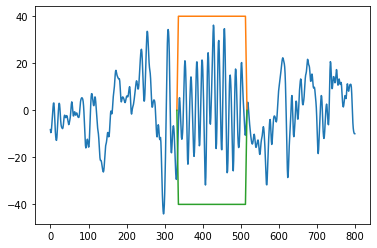

In [38]:
plt.plot(x_test_pre[1])
plt.plot(jaja,lala*40)
plt.plot(jaja,lala*-40)

In [20]:
large=len(y_test[1])
a=[]
for i in range(large):
    if(y_test[1][i]==1):
        a.append(time[i])
        

In [26]:
lorge=len(a)
xd=np.ones(lorge)

In [33]:
lala=[0]
for i in xd:
    lala.append(i)
lala.append(0)
lala=np.array(lala)

In [39]:
y_test_pre[1]

array([333, 515])

In [36]:
jaja=[332]
for i in a:
    jaja.append(i)
jaja.append(516)
jaja=np.array(jaja)

In [37]:
jaja

array([332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380,
       384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432,
       436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484,
       488, 492, 496, 500, 504, 508, 512, 516])